# Stroke Prediction Model

## 1. Introduction

**Context**

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. 

This dataset contains relevant patient information in each row, including parameters such as gender, age, various diseases, and smoking status. 

It is designed to be used for building a machine learning model that can predict a patient's likelihood of experiencing a stroke. The ability to accurately determine which patients have a high stroke risk will empower doctors to provide timely advice and guidance to both patients and their families on how to act in case of an emergency.


**Goals:**

        Reduce preventable stroke deaths by identifying high-risk patients for proactive care.

        Improve clinical decision-making with interpretable risk predictions.

**Objectives:**


        Develop a model with ≥70% recall (minimize missed strokes) while keeping precision ≥15%.

        Ensure generalizability by validating on test set (ROC-AUC ≥0.8 and PR-AUC ≥0.2).       
        
        Identify top 3 clinical risk factors driving predictions using SHAP values.

        Deploy the model.


**Dataset Overview**

The dataset contains 5110 patient observations. It includes 11 independent variables (6 numerical, 5 categorical) and 1 target variable (Stroke).

## 2. Exploratory Data Analysis (EDA)

### A. Data loading & Initial checks

In [1]:
%load_ext jupyter_black

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import shap
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import (
    levene,
    chi2_contingency,
    randint,
    uniform,
    shapiro,
    mannwhitneyu,
)
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_curve,
    auc,
    ConfusionMatrixDisplay,
    confusion_matrix,
    precision_recall_curve,
)
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.ensemble import (
    GradientBoostingClassifier,
    VotingClassifier,
)
from sklearn.svm import SVC
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_predict,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.inspection import DecisionBoundaryDisplay, permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from typing import Dict, Optional, List, Tuple
from imblearn.over_sampling import SMOTE
from optuna.samplers import TPESampler
from phik import phik_matrix, resources, report
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import joblib
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
plt.style.use("tableau-colorblind10")

In [3]:
from Data.utils import (
    bootstrap_median_diff,
    plot_distribution_numerical,
    stacked_bar_with_percent,
    calculate_vif,
    add_outlier_feature,
    evaluate_feature_addition_auc,
    tune_model,
)

In [4]:
df_original = pd.read_csv(r"Data\healthcare-dataset-stroke-data.xls")
df = df_original.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.shape

(5110, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


**Feature descriptions:**
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood (mg/dL)
10) bmi: body mass index (kg/m2)
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [7]:
categorical = df.select_dtypes(include="object").columns.tolist()
numerical = df.select_dtypes(exclude="object").columns.tolist()
binary = [col for col in df.columns if df[col].nunique() == 2]

print(f"Numerical features: {numerical}")
print(f"Categorical features: {categorical}")
print(f"Binary features: {binary}")

Numerical features: ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
Categorical features: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Binary features: ['hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'stroke']


In [8]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


**Key Insights:**

    - Missing Data in BMI: The bmi column is incomplete, with 201 missing values (≈3.9% of the total 5110 records)

    - High Class Imbalance: The stroke target variable has a mean of only ≈0.0487. This means only about 4.87% of the patients in the dataset experienced a stroke, indicating a highly imbalanced classification problem.

    - Wide Age Range: The dataset includes subjects ranging from infants (min=0.08 years) up to 82 years. The mean age is 43.23 years.

    - Overweight Population: The average bmi is ≈28.89, placing the typical subject in the overweight category (BMI 25.0−29.9), nearing the obesity threshold (≥30).

    - Prevalence of Conditions: Hypertension affects about 9.75% of the population, and heart disease affects about 5.40%.

    - Glucose Range: The avg_glucose_level has a large spread (std≈45.28) and ranges up to 271.74, suggesting the presence of individuals with normal, pre-diabetic, and diabetic blood sugar levels.

**Checking for missing values.**

In [9]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [10]:
percentage_missing_bmi = df["bmi"].isna().sum() / len(df) * 100
print(f"{percentage_missing_bmi:.2f}")

3.93


BMI is the only feature with missing values (~4%).

In [11]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Total rows: 5,110


Target Distribution

    Stroke prevalence is low (4.87%) imbalanced dataset.

Feature Characteristics

    Age ranges from 0.08 to 82 years, mean ~43. Likely includes newborns or data errors (age <1).

    Hypertension: ~9.75% positive

    Heart disease: ~5.4% positive

    Avg glucose: mean ~106, range 55–272 Skewed distribution (right tail likely).
    271 glucose is  biologically plausible, it could indicate unmanaged diabetes.

    BMI: mean ~28.9 (overweight range)

    Range from 10.3 to 97.6. Some outliers. BMI > 30 - obesity, BMI > 60 is rare, but record for BMI is 186
    https://en.wikipedia.org/wiki/Jon_Brower_Minnoch

**Comparing dataset with and without NA**

In [12]:
df_no_Na = df.dropna()
df_no_Na.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,37064.313506,42.865374,0.091872,0.049501,105.305150,28.893237,0.042575
std,20995.098457,22.555115,0.288875,0.216934,44.424341,7.854067,0.201917
min,77.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,18605.000000,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,37608.000000,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,55220.000000,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Stroke Rate Difference:

    df with missing BMI group: 4.87% stroke rate

    df Non-missing group (droped NA): 4.26% stroke rate

Missing BMI may be informative (not random). Needs imputation to avoid bias (No dropping NA rows).

**Checking for duplicates.**

In [13]:
print(
    f"Duplicates: {df.duplicated().sum()}, {(df.duplicated().sum() / len(df) * 100):.2f}%"
)

Duplicates: 0, 0.00%


No duplicates in dataset.

### B. Univariate Analysis

**Distribution of target variable - Stroke**

In [14]:
stroke_counts = df["stroke"].value_counts()
stroke_counts

stroke
0    4861
1     249
Name: count, dtype: int64

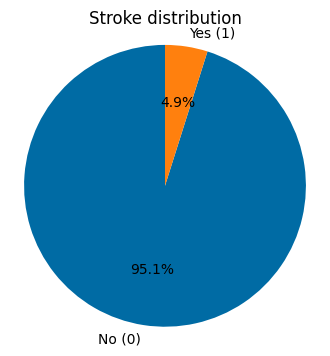

In [15]:
labels = ["No (0)", "Yes (1)"]

plt.figure(figsize=(4, 4))
plt.pie(
    stroke_counts,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
)
plt.title("Stroke distribution")
plt.axis("equal")
plt.show()

Globally, 1 in 4 adults over the age of 25 will have a stroke in their lifetime  https://www.world-stroke.org/world-stroke-day-campaign/about-stroke/impact-of-stroke

While our dataset shows a stroke incidence of 4.9%, which is significantly lower than this average, it's important to note that our data includes individuals under 25. 

~ 5% stroke creates an imbalanced dataset, which can be addressed using techniques like oversampling (SMOTE), stratified splits, and balanced evaluation metrics (e.g., PR AUC, F1-score).

**Distribution plots for numerical features.**

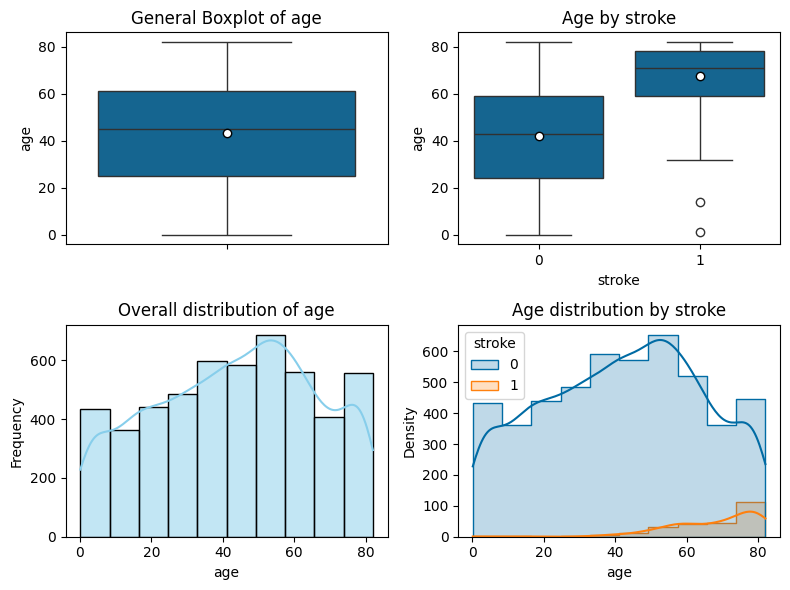

In [16]:
plot_distribution_numerical(df, "age")

The age distribution is non-normal. A substantial number of observations are concentrated within the 50-82 age range, and no other significant anomalies were detected.

We observed two outliers in individuals under 20 years of age. Age distribution split by stroke shows stroke's strong correlation with older age. 

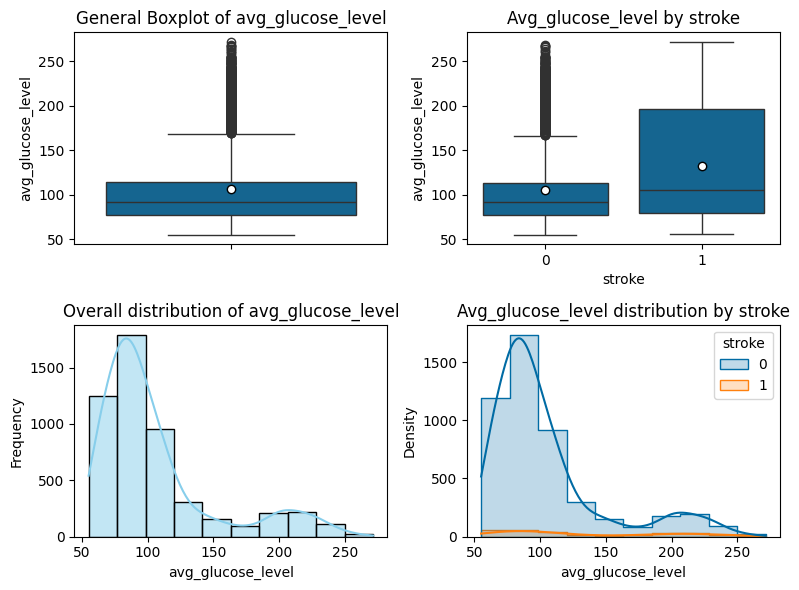

In [18]:
plot_distribution_numerical(df, "avg_glucose_level")

Normal glucose levels are typically between 70-100 mg/dL. Clinically, a threshold of 140 mg/dL indicates prediabetes (glucose > 140 mg/dL). The distribution of average glucose levels is close to normal but right-skewed, with numerous outliers exceeding 170 mg/dL, no other anomalies.

When stratified by stroke status, the average glucose distributions reveal higher mean and median glucose levels for patients with stroke. This strongly suggests that glucose level is a valuable feature for stroke prediction.

We will create feature for glucose outliers.

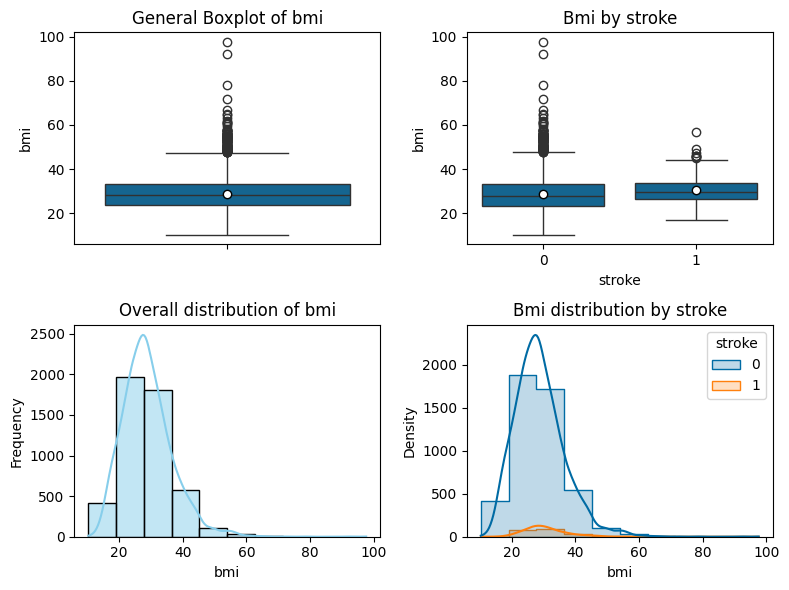

In [19]:
plot_distribution_numerical(df, "bmi")

The BMI distribution is approximately normal, though right-skewed with numerous outliers exceeding 50 kg/m². A mean BMI of 28.9 suggests the patient population is, on average, overweight. While a BMI greater than 30 kg/m² is classified as obesity (with values over 60 kg/m² being rare), no other significant data anomalies were identified.

When stratified by stroke status, the BMI distributions reveal slightly higher mean and median BMI for patients with stroke, suggesting that BMI could be a predictive factor for stroke.

We will create feature for BMI outliers.

**Countplots for categorical features**

In [20]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [21]:
df[df["gender"] == "Other"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


The 'Other' gender category, appearing in only a single row, would result in a highly sparse column after OneHotEncoding. Therefore, to avoid this sparsity and potential modeling issues, and taking into account, that stroke is 0, I will drop this row.

In [22]:
df = df[df["gender"] != "Other"]
df.shape

(5109, 12)

In [23]:
df["gender"].value_counts(normalize=True)

gender
Female    0.586025
Male      0.413975
Name: proportion, dtype: float64

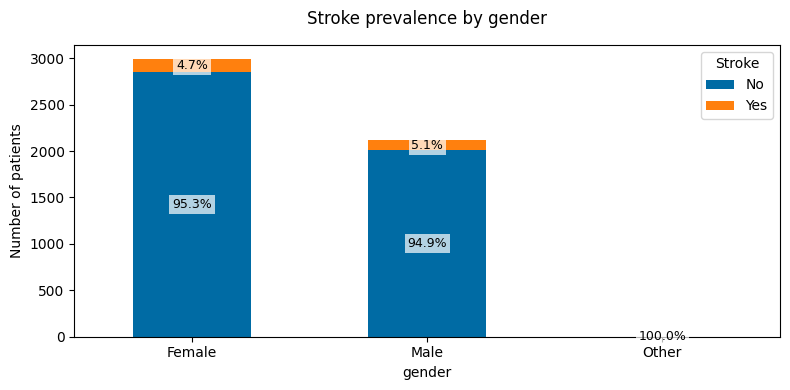

In [6]:
stacked_bar_with_percent(df, "gender")

Although there are more females than males in this dataset, males show a very slightly higher stroke rate than females in this dataset, both figures are remarkably close to the overall dataset average of 4.9%. This suggests that gender, by itself, does not appear to be a substantial differentiating factor for stroke risk in this particular population.

In [25]:
df["hypertension"].value_counts(normalize=True)

hypertension
0    0.902525
1    0.097475
Name: proportion, dtype: float64

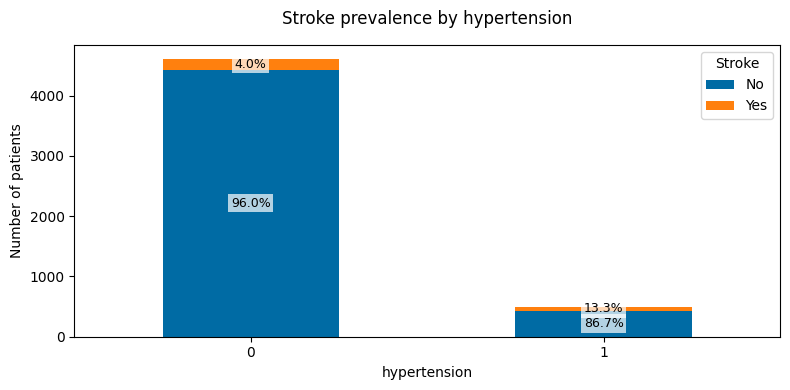

In [7]:
stacked_bar_with_percent(df, "hypertension")

Patients with hypertension (1) have a significantly higher stroke rate (13.3%) compared to those without hypertension (0), whose stroke rate is much lower (4%). This suggests hypertension is a strong risk factor for stroke.

In [27]:
df["heart_disease"].value_counts(normalize=True)

heart_disease
0    0.945978
1    0.054022
Name: proportion, dtype: float64

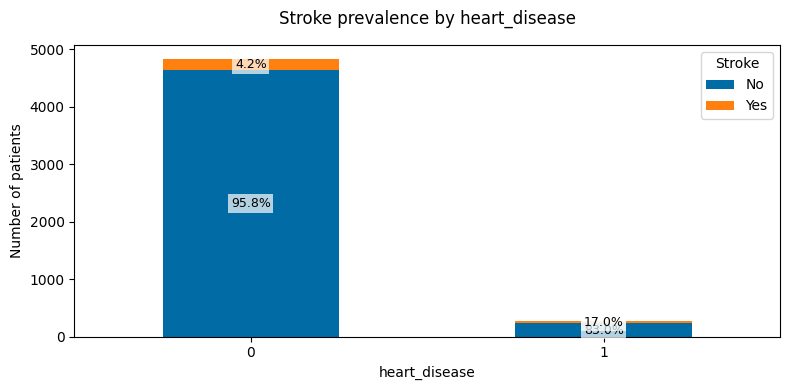

In [8]:
stacked_bar_with_percent(df, "heart_disease")

Patients with heart disease have a substantially higher risk of stroke (17.0%) compared to those without heart disease (4.2%). This indicates that heart disease could be a significant independent risk factor for stroke in this dataset.

In [29]:
df["ever_married"].value_counts(normalize=True)

ever_married
Yes    0.656293
No     0.343707
Name: proportion, dtype: float64

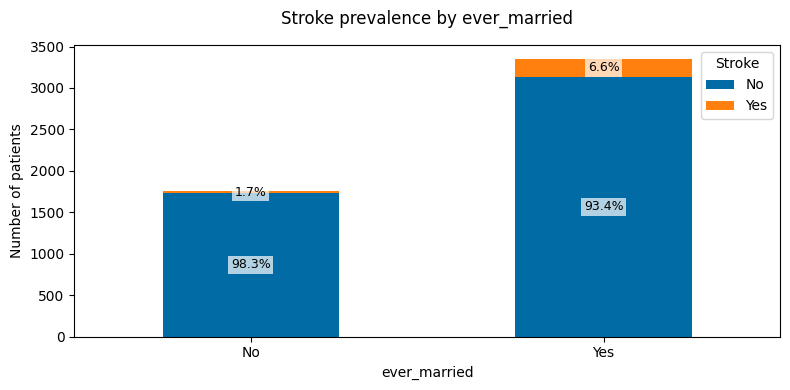

In [9]:
stacked_bar_with_percent(df, "ever_married")

Individuals who have been ever married appear to have a significantly higher stroke rate (6.56%) in this dataset compared to those who have never been married (1.65%). This suggests that "ever married" status is a notable factor associated with an increased risk of stroke.

In [31]:
df["work_type"].value_counts(normalize=True)

work_type
Private          0.572323
Self-employed    0.160305
children         0.134469
Govt_job         0.128597
Never_worked     0.004306
Name: proportion, dtype: float64

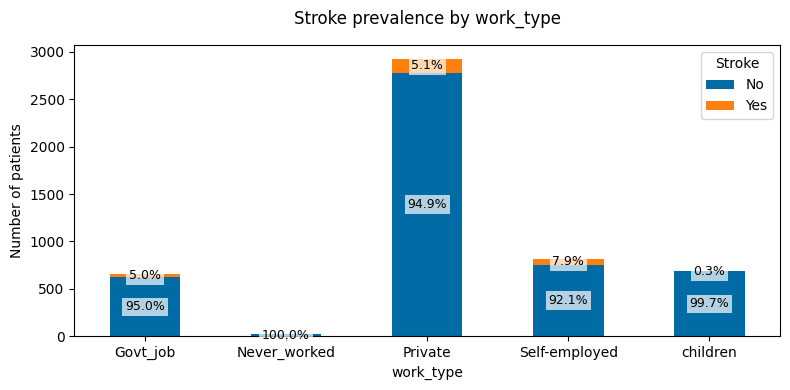

In [10]:
stacked_bar_with_percent(df, "work_type")

For Government job (5.0%) and Private (5.1%) sectors, the stroke percentages are indeed close to the overall dataset of 4.9%.
Individuals categorized as 'Never_worked' (0%) and the 'children' (0.3%) category displays an extremely low stroke rate.

The 'Self-employed' group exhibits a distinctly higher stroke rate (7.9%), indicating a potentially elevated risk for stroke within this work type.

In [33]:
df["Residence_type"].value_counts(normalize=True)

Residence_type
Urban    0.508123
Rural    0.491877
Name: proportion, dtype: float64

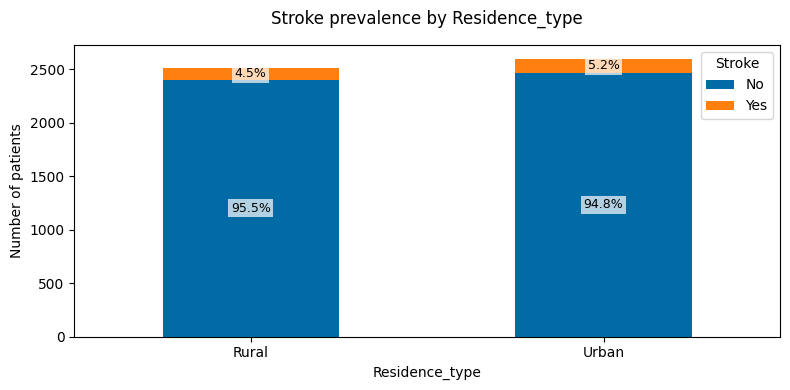

In [11]:
stacked_bar_with_percent(df, "Residence_type")

While the difference is not substantial, individuals residing in Urban areas appear to have a slightly higher incidence of stroke compared to those in Rural areas within this dataset. This suggests that Residence_type might be a minor contributing factor to stroke risk.

In [35]:
df["smoking_status"].value_counts(normalize=True)

smoking_status
never smoked       0.370327
Unknown            0.302212
formerly smoked    0.173028
smokes             0.154433
Name: proportion, dtype: float64

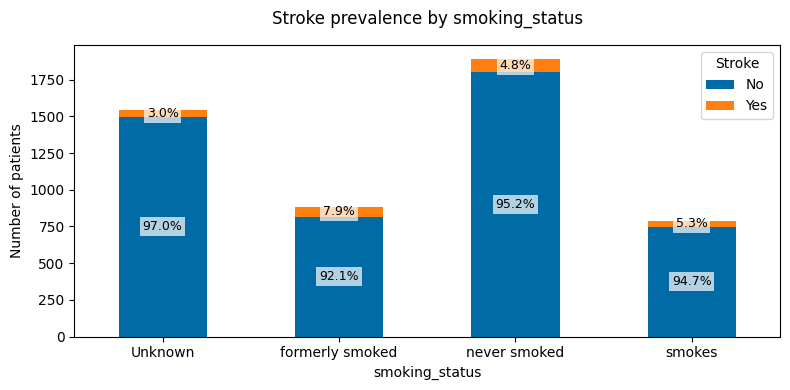

In [12]:
stacked_bar_with_percent(df, "smoking_status")

This data strongly suggests that both current smoking (5.3%) and a history of smoking ('formerly smoked' - 7.9%) are associated with an increased risk of stroke, with 'formerly smoked' individuals showing the highest stroke incidence in this dataset. 'Never smoked' (4.8%) individuals appear to have a slightly lower risk than average.

**Univariate Analysis summary**

Strong Risk Factors:

    Age: There is a strong correlation between stroke and older age.
    
    Heart Disease: Patients with heart disease exhibit a substantially higher stroke rate.
    
    Hypertension: Similarly, individuals with hypertension show a significantly higher stroke rate.
    
    Average Glucose Level: Patients with stroke tend to have higher mean and median average glucose levels.
    
    Smoking Status: Both current smoking and formerly smoked are associated with an increased risk of stroke.
    
    Ever Married Status: Patients who have been ever married appear to have higher stroke rate.

Moderate to Minor Contributing Factors:

    Work Type: The 'Self-employed' group exhibits a distinctly higher rate (7.9%), indicating a potentially elevated risk.
    
    BMI: Stroke patients tend to have slightly higher mean and median BMI.
    
    Residence Type: Individuals in Urban areas show a slightly higher incidence of stroke.

Factors with Less Differentiation / Low Risk:

    Gender: Males show only a very slightly higher stroke rate than females.

### C. Multivariate Analysis

**Phi-k Correlation matrix**

interval columns not set, guessing: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']


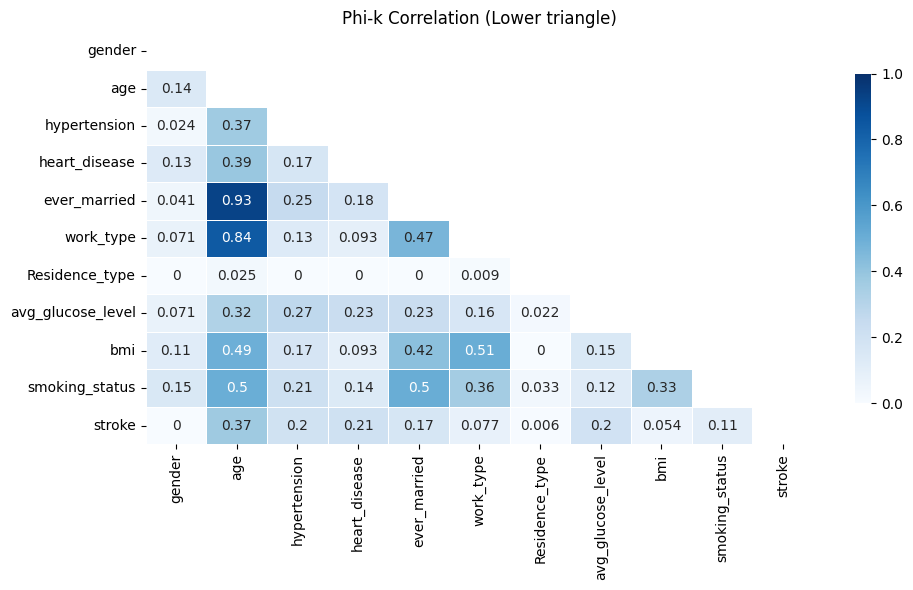

In [37]:
df = df.drop(columns=["id"])

phik_corr = df.phik_matrix()

mask = np.triu(np.ones_like(phik_corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(
    phik_corr,
    mask=mask,
    annot=True,
    cmap="Blues",
    vmin=0,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Phi-k Correlation (Lower triangle)")
plt.tight_layout()

1. Dependency with Stroke:

    Age (0.37): This exhibits the strongest dependency with stroke. It indicates a moderate association, suggesting a notable relationship where higher age is strongly associated with an increased likelihood of stroke.

    Heart Disease (0.21), Avg Glucose Level (0.20), Hypertension (0.20): These demonstrate weak to moderate dependencies with stroke.

    Ever Married (0.17), Smoking Status (0.11): These show very weak associations/dependencies with stroke.

3. Dependency with Age:

    Ever Married (0.93): This indicates an extremely strong dependency/association. It suggests a nearly perfect relationship, which is expected given age significantly influences marital status over time.

    Work Type (0.84): This also exhibits a very strong dependency/association. This is logical, as individuals' work types change significantly as they age (e.g., from "children" or "never worked" to "private," "government job," or "self-employed").

    BMI (0.49): This indicates a moderate dependency/association, suggesting a tendency for BMI to be higher in older individuals.

    Smoking Status (0.5): This shows a moderate dependency/association, suggesting that as people age, their smoking status tends to vary (e.g., they might transition to 'formerly smoked' or 'smokes,' or 'never smoked' status might become less prevalent in older age groups).

    Heart Disease (0.39) & Hypertension (0.37): These demonstrate weak to moderate dependencies/associations with age. This is expected, as the prevalence of both conditions generally increases with age.

The high dependencies of age with factors like ever_married, work_type, BMI, smoking_status, hypertension, and heart_disease are important. Since age itself is the strongest predictor of stroke, it's possible that some of the weaker dependencies of other features with stroke are actually indirect effects, mediated largely through their strong relationship with age. This highlights the importance of age as a central risk factor.

**Multicollinearity check**

As the phi-K correlation matrix revealed strong dependencies among the independent variables, we will assess for multicollinearity.

In [38]:
df["bmi"] = df["bmi"].fillna(df["bmi"].median())
calculate_vif(df, target_column="stroke")

,feature,VIF
0,const,18.73
1,age,1.29
2,bmi,1.14
3,hypertension,1.10
4,avg_glucose_level,1.10
5,heart_disease,1.09


All non-constant features have VIF < 2:

    No significant multicollinearity.

    Features are mostly independent of one another.

## 3. Statistical Inference

**1. Target Population**

Target population: patients (age 0.08 to 82 years) from which this data set was drawn.

Sample size: 5,110 patients with the following characteristics:

    4.87% experienced stroke (249 cases)

    Hypertension: 9.75%

    Heart disease: 5.40%

    Average glucose: 106.1 ± 45.3 mg/dL

    BMI: 28.9 ± 7.9 (with 201 missing values)

The target variable is stroke (binary: 0 = no stroke, 1 = stroke).

We want to infer about relationships between features and stroke occurrence in this population.

We'll examine these relationships with threshold for statistical significance α = 0.05.

**2. Hypotheses testing**

**Hypothesis 1: Average age differs between stroke and no-stroke patients**

**Null Hypothesis (H₀):** *The mean age of stroke and no-stroke patients is the same.*

**Alternative Hypothesis (H₁):** *The mean age of stroke and no-stroke patients differs.*

- Test: Two-sample t-test
- Assumptions: Independent samples (no duplicates), approximately normal distribution or large sample, equal variances.

**Checking for normality.**

Using the Shapiro-Wilk test.

Null Hypothesis (H₀): Sample looks normal. 
Alternative Hypothesis (H₁): Sample does not look normal.

In [39]:
stroke_0 = df[df["stroke"] == 0]["age"]
stroke_1 = df[df["stroke"] == 1]["age"]

stat_yes, p_yes = shapiro(stroke_1)
stat_no, p_no = shapiro(stroke_0)

print(f"Stroke (1 - Yes) - p-value: {p_yes:.4f}")
print(f"Stroke (0 -  No) - p-value: {p_no:.4f}")

Stroke (1 - Yes) - p-value: 0.0000
Stroke (0 -  No) - p-value: 0.0000


Both p-values < 0.05: Reject H₀ - Samples does not look normal.

**Checking for equal variances.**

Null Hypothesis (H₀): The variances of annual income of people who purchased travel insurance are equal to those who did not.

Alternative Hypothesis (H₁): The variances of annual income of buyers and non-buyers are different.

In [40]:
stat, p = levene(stroke_0, stroke_1)
print(f"Levene's p-value: {p:.4f}")

Levene's p-value: 0.0000


p-value < 0.05: Reject H₀ - variances are unequal.

Distributions are not normal and variances are unequal, the assumptions for a standard two-sample t-test are violated. We should not use the regular t-test.

**Using the Mann-Whitney U Test**

In [41]:
stat, p = mannwhitneyu(stroke_1, stroke_0, alternative="two-sided")
print(f"Mann-Whitney U Test p-value: {p:.4f}")

Mann-Whitney U Test p-value: 0.0000


P-value < 0.05. Reject H₀ - The average age of stroke patients statistically significant differs from no-stroke patients.

**Bootstrap CI for the median difference**

In [42]:
bootstrap_ci = bootstrap_median_diff(stroke_1, stroke_0)
print(
    f"\nBootstrap CI for the median difference (Yes - No): [{bootstrap_ci[0]:.2f}, {bootstrap_ci[1]:.2f}]"
)


Bootstrap CI for the median difference (Yes - No): [25.00, 31.00]


This interval does not include zero, reinforcing that the difference in medians is statistically significant. **These results suggest that patients who experience a stroke tend to be significantly older than those who do not.**

**Hypothesis 2: Average glucose level differs between stroke and no-stroke patients**

**Null Hypothesis (H₀):** *Average glucose level of stroke and no-stroke patients is the same.*

**Alternative Hypothesis (H₁):** *Average glucose level of stroke and no-stroke patients differs.*


**Checking for normality.**

Using the Shapiro-Wilk test.

Null Hypothesis (H₀): Sample looks normal. 
Alternative Hypothesis (H₁): Sample does not look normal.

In [43]:
stroke_agl_0 = df[df["stroke"] == 0]["avg_glucose_level"]
stroke_agl_1 = df[df["stroke"] == 1]["avg_glucose_level"]

stat_yes, p_yes = shapiro(stroke_agl_1)
stat_no, p_no = shapiro(stroke_agl_0)

print(f"Stroke (1 - Yes) - p-value: {p_yes:.4f}")
print(f"Stroke (0 -  No) - p-value: {p_no:.4f}")

Stroke (1 - Yes) - p-value: 0.0000
Stroke (0 -  No) - p-value: 0.0000


Both p-values < 0.05: Reject H₀ - Samples does not look normal.

**Checking for equal variances.**

Null Hypothesis (H₀): The variances of annual income of people who purchased travel insurance are equal to those who did not.

Alternative Hypothesis (H₁): The variances of annual income of buyers and non-buyers are different.

In [44]:
stat, p = levene(stroke_agl_0, stroke_agl_1)
print(f"Levene's p-value: {p:.4f}")

Levene's p-value: 0.0000


p-value < 0.05: Reject H₀ - variances are unequal.

Distributions are not normal and variances are unequal, the assumptions for a standard two-sample t-test are violated. We should not use the regular t-test.

**Using the Mann-Whitney U Test**

In [45]:
stat, p = mannwhitneyu(stroke_agl_1, stroke_agl_0, alternative="two-sided")
print(f"Mann-Whitney U Test p-value: {p:.4f}")

Mann-Whitney U Test p-value: 0.0000


P-value < 0.05. Reject H₀ - The average glucose level of stroke patients statistically significant differs from no-stroke patients.


**Bootstrap CI for the median difference**

In [46]:
bootstrap_ci = bootstrap_median_diff(stroke_agl_1, stroke_agl_0)
print(
    f"\nBootstrap CI for the median difference (Yes - No): [{bootstrap_ci[0]:.2f}, {bootstrap_ci[1]:.2f}]"
)


Bootstrap CI for the median difference (Yes - No): [6.42, 21.23]


Since this interval does not include zero and is entirely positive, it indicates that **patients who have experienced a stroke tend to have significantly higher average glucose levels compared to those who have not.**

**Hypothesis 3: The proportion of hypertension is the same in stroke and no-stroke groups**

**Null Hypothesis (H₀):** *Proportion of hypertension in stroke group is the same like proportion in no-stroke group.*

**Alternative Hypothesis (H₁):** *Proportion of hypertension differs between groups.*

- Test: ztest.

**Checking for sample size**

Both feature and target are binary (0/1), we do not need to check for normality in the usual sense  we check if the sample size is large enough for the normal approximation to be valid (bigger than 5)

In [47]:
grouped = df.groupby("hypertension")["stroke"].agg(["sum", "count"])

grouped.columns = ["stroke", "total"]
grouped["proportion"] = grouped["stroke"] / grouped["total"]

grouped["n*p"] = grouped["total"] * grouped["proportion"]
grouped["n*(1-p)"] = grouped["total"] * (1 - grouped["proportion"])
grouped["z_test_valid"] = (grouped["n*p"] >= 5) & (grouped["n*(1-p)"] >= 5)

print(grouped)

              stroke  total  proportion    n*p  n*(1-p)  z_test_valid
hypertension                                                         
0                183   4611    0.039688  183.0   4428.0          True
1                 66    498    0.132530   66.0    432.0          True


**Z-test**

In [48]:
grouped = df.groupby("hypertension")["stroke"].agg(["sum", "count"])
n_successes = grouped["sum"].values
n_obs = grouped["count"].values

z_stat, p_val = proportions_ztest(count=n_successes, nobs=n_obs)
print(f"Z-statistic: {z_stat:.3f}, p-value: {p_val:.4f}")

ci_group_0 = proportion_confint(
    count=grouped.loc[0, "sum"], nobs=grouped.loc[0, "count"], alpha=0.05
)
ci_group_1 = proportion_confint(
    count=grouped.loc[1, "sum"], nobs=grouped.loc[1, "count"], alpha=0.05
)
p0 = grouped.loc[0, "sum"] / grouped.loc[0, "count"]
p1 = grouped.loc[1, "sum"] / grouped.loc[1, "count"]
print(f"Proportion with stroke (No hypertension): {p0:.3f}")
print(f"Proportion with stroke (With hypertension): {p1:.3f}")

print(f"Group 0 (No hypertension) CI: ({ci_group_0[0]:.3f}, {ci_group_0[1]:.3f})")
print(f"Group 1 (With hypertension) CI: ({ci_group_1[0]:.3f}, {ci_group_1[1]:.3f})")

Z-statistic: -9.141, p-value: 0.0000
Proportion with stroke (No hypertension): 0.040
Proportion with stroke (With hypertension): 0.133
Group 0 (No hypertension) CI: (0.034, 0.045)
Group 1 (With hypertension) CI: (0.103, 0.162)


P-value < 0.05, There is statistically **significant difference in the proportion of individuals experiencing a stroke between those with and without hypertension.**
The proportion of stroke is substantially higher in the group with hypertension (13.3%) compared to the group without hypertension (4.0%). The confidence intervals confirm these groups are distinct (no overlap).

**Statistical Inference summary**

Statistical tests demonstrate that patients' **average age, average glucose level, and hypertension status differ significantly between individuals with stroke and those without stroke.**

## 4. Machine Learning Modeling

### A. Feature Engineering

**Age and hypertension**

Given Age's strong dependency (0.37) and Hypertension's moderate dependency (0.20) with stroke, we will explore a new interaction feature: Age * Hypertension.

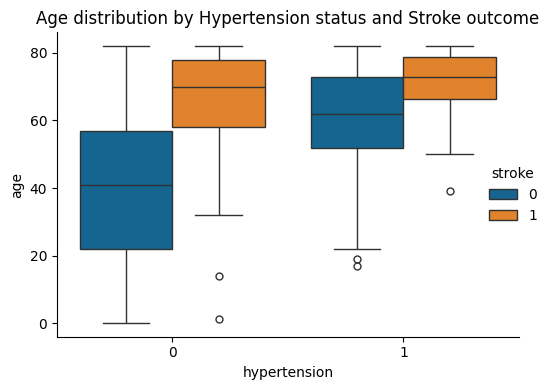

In [49]:
sns.catplot(
    data=df, x="hypertension", y="age", hue="stroke", kind="box", height=4, aspect=1.2
)
plt.title("Age distribution by Hypertension status and Stroke outcome")
plt.tight_layout()

Median for age when patient has stroke with hypertension is higher than without hypertension. Age * hypertension feature could have potential to improve model's ability to predict stroke, especially if the combined effect of being older and hypertensive carries a uniquely higher risk.

**Age and glucose**

Age's strong dependency (0.37) and Glucose's moderate dependency (0.20) with stroke, we will explore a new interaction feature: Age * Glucose.

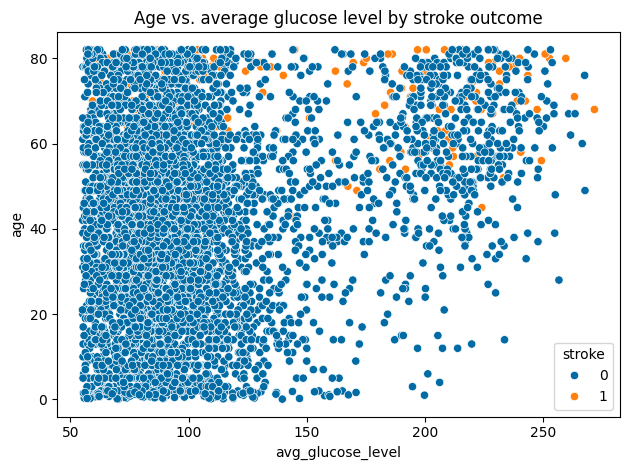

In [50]:
sns.scatterplot(data=df, x="avg_glucose_level", y="age", hue="stroke")
plt.title("Age vs. average glucose level by stroke outcome")
plt.tight_layout()

In [51]:
df["age_glucose"] = df["age"] * df["avg_glucose_level"]
df[["stroke", "age_glucose"]].corr()

,stroke,age_glucose
stroke,1.000000,0.246548
age_glucose,0.246548,1.000000


The age_glucose feature shows a moderate level of dependency with stroke. This means it's capturing some relevant information, and it's worth evaluating its impact on your model's performance.

**Risk factors**

We will consolidate individual risk indicators: hypertension, heart_disease, smoking into a single numerical score, hypothesized to provide a clearer signal of overall stroke risk to the predictive model.

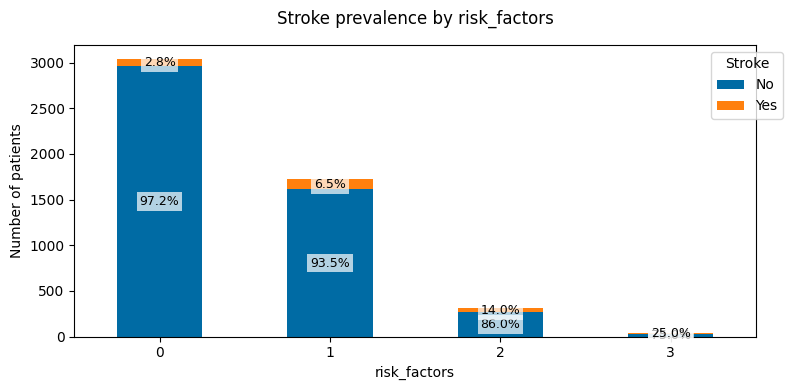

In [52]:
df["risk_factors"] = (
    df["hypertension"]
    + df["heart_disease"]
    + df["smoking_status"].isin(["smokes", "formerly smoked"]).astype(int)
)
stacked_bar_with_percent(df, "risk_factors")

The data reveals a clear positive association: as a patient's accumulated risk factors (hypertension, heart disease, and smoking status) increase, the likelihood or incidence of stroke also consistently rises.

**BMI, Glucose outliers**

These features showed some outliers, so we will introduce new features: glucose outlier and bmi outlier.

**Evaluation of new features**

We will evaluate the new features using a LightGBM model by comparing the ROC-AUC results of a base model (using 'age', 'avg_glucose_level', 'bmi') against a model that includes the new feature. Using cross validation on train set.

We will reset the dataframe. To avoid data leakage we will begin with data split.

BMI NA we will fill with median.

In [7]:
df = df_original.copy()
df = df[df["gender"] != "Other"]
X = df.drop(columns=["stroke", "id"])
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
X_train["bmi"] = X_train["bmi"].fillna(X_train["bmi"].median())
X_train["age_hypertension"] = X_train["age"] * X_train["hypertension"]
X_train["age_glucose"] = X_train["age"] * X_train["avg_glucose_level"]
X_train["risk_factors"] = (
    X_train["hypertension"]
    + X_train["heart_disease"]
    + X_train["smoking_status"].isin(["smokes", "formerly smoked"]).astype(int)
)
X_train = add_outlier_feature(X_train, column="avg_glucose_level")
X_train = add_outlier_feature(X_train, column="bmi")
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,age_hypertension,age_glucose,risk_factors,avg_glucose_level_outlier,bmi_outlier
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0.0,3322.08,0,0,0
3745,Female,29.0,0,0,No,Private,Urban,84.19,21.2,never smoked,0.0,2441.51,0,0,0
4184,Female,35.0,0,0,Yes,Private,Rural,119.40,22.9,never smoked,0.0,4179.00,0,0,0
3410,Male,38.0,0,0,Yes,Private,Rural,108.68,32.7,never smoked,0.0,4129.84,0,0,0
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0.0,1152.76,0,0,0


In [10]:
base_features = ["age", "avg_glucose_level", "bmi"]
new_features = [
    "risk_factors",
    "age_glucose",
    "age_hypertension",
    "avg_glucose_level_outlier",
    "bmi_outlier",
]
for feature in new_features:
    auc = evaluate_feature_addition_auc(X_train, y_train, base_features, feature)
    print(f"{auc}\n")

                 Model  ROC-AUC
0                 Base   0.8206
1  Base + risk_factors   0.8183

                Model  ROC-AUC
0                Base   0.8206
1  Base + age_glucose   0.8103

                     Model  ROC-AUC
0                     Base   0.8206
1  Base + age_hypertension   0.8249

                              Model  ROC-AUC
0                              Base   0.8206
1  Base + avg_glucose_level_outlier   0.8176

                Model  ROC-AUC
0                Base   0.8206
1  Base + bmi_outlier   0.8230



Among all the new features tested, only age_hypertension and bmi_outlier improved the model's ROC AUC. Therefore, we will retain these two features and exclude the others (age_glucose, age_hypertension, avg_glucose_level_outlier) from the final model.

### B. Data Preparation

We will reset the dataframe once more.

In [11]:
df = df_original.copy()
df = df[df["gender"] != "Other"]
df["age_hypertension"] = df["age"] * df["hypertension"]
df = add_outlier_feature(df, column="bmi")

print(
    f"{ df.shape},\n Duplicated: {df.duplicated().sum()}\n Missing values:\n{df.isna().sum()}"
)

(5109, 14),
 Duplicated: 0
 Missing values:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
age_hypertension       0
bmi_outlier            0
dtype: int64


Instead of splitting the data into train, validation, and test sets, we will split it into train and test sets, and use cross-validation on the training set.

Because the target variable is highly disbalanced, we will use option stratify=y.

In [12]:
X = df.drop(columns=["stroke", "id"])
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} samples, Test: {X_test.shape[0]} samples")

Train: 4087 samples, Test: 1022 samples


### C. Pipeline Preprocessing 

The BMI feature contains NaN values. We can't drop these rows because it would impact our target variable, 'stroke', changing its overall prevalence from 4.87% to 4.26%. 

To find the optimal imputer and scaler, also to find do we need to use SMOTE, we will use GridSearchCV with the LightGBM model.

For categorical features, we will use OneHotEncoder with the option drop="if_binary" to drop unnecessary columns if the feature is binary.

In [13]:
categorical = X.select_dtypes(include="object").columns.tolist()
numerical = X.select_dtypes(exclude="object").columns.tolist()

num_pipe = Pipeline([("imputer", "passthrough"), ("scaler", FunctionTransformer())])

cat_pipe = Pipeline(
    [("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    [("num", num_pipe, numerical), ("cat", cat_pipe, categorical)]
)

In [14]:
N_pos = np.sum(y_train == 1)
N_neg = np.sum(y_train == 0)
scale_pos_weight_val = N_neg / N_pos

pipesearch = imbPipeline(
    [
        ("preprocessor", preprocessor),
        ("smote", "passthrough"),
        (
            "classifier",
            LGBMClassifier(
                force_row_wise=True,
                verbose=-1,
                random_state=42,
                scale_pos_weight=scale_pos_weight_val,
            ),
        ),
    ]
)

In [16]:
log_transform = FunctionTransformer(
    func=np.log1p, inverse_func=np.expm1, validate=False
)

param_grid = {
    "preprocessor__num__imputer": [
        SimpleImputer(strategy="median", add_indicator=True),
        SimpleImputer(strategy="mean", add_indicator=True),
        KNNImputer(n_neighbors=2),
        KNNImputer(n_neighbors=3),
        KNNImputer(n_neighbors=5),
    ],
    "preprocessor__num__scaler": [
        StandardScaler(),
        RobustScaler(),
        "passthrough",
        log_transform,
    ],
    "smote": [SMOTE(random_state=42), "passthrough"],
    "classifier__scale_pos_weight": [1, scale_pos_weight_val],
}

In [17]:
grid = GridSearchCV(pipesearch, param_grid, cv=5, scoring="average_precision", n_jobs=1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)

Best Params: {'classifier__scale_pos_weight': 19.537688442211056, 'preprocessor__num__imputer': SimpleImputer(add_indicator=True, strategy='median'), 'preprocessor__num__scaler': StandardScaler(), 'smote': 'passthrough'}
Best Score: 0.20489337121252751


**Defining preprocesor**

In [62]:
cat_pipe = Pipeline(
    [("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))]
)
num_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler()),
    ]
)
preprocessor = ColumnTransformer(
    [("num", num_pipe, numerical), ("cat", cat_pipe, categorical)]
)

### D. Model Selection

We will use LogisticRegression, XGBoost, CatBoost, LightGBM, Gradient Boosting

Logistic Regression

    A linear model for binary classification.

    Fast, interpretable, and good baseline for performance comparison.

XGBoost (Extreme Gradient Boosting)

    Optimized gradient boosting algorithm.

    Known for speed and performance on structured/tabular data.

CatBoost

    Gradient boosting by Yandex, handles categorical features natively.

    Often requires less preprocessing and performs well on diverse datasets.

LightGBM (Light Gradient Boosting Machine)

    Gradient boosting by Microsoft, optimized for large datasets.

    Fast training with lower memory usage; supports categorical features.

Gradient Boosting (Scikit-learn)

    Classic gradient boosting implementation.

    Slower than XGBoost/LightGBM but good for small to medium data.


**Most Important Metrics**

Average Precision (PR-AUC) - Area under Precision-Recall curve:	Summarizes precision-recall trade-off. Better than ROC-AUC for extreme imbalance.

ROC-AUC	- Area under ROC curve:	Measures how well the model distinguishes between classes (0.5 = random, 1 = perfect). Robust to imbalance; evaluates ranking performance

Recall (Sensitivity, True Positive Rate) -	TP / (TP + FN):	percent of actual strokes correctly predicted. Critical to detect as many strokes as possible. Objective > 0.7.

Precision (Positive Predictive Value)- TP / (TP + FP):	percent of predicted strokes that are real.	Avoids too many false alarms. Objective > 0.15.

F1-Score - 2 * (Precision * Recall) / (Precision + Recall)	Harmonic mean of Precision and Recall. Good metric for imbalanced classification problems.


In [63]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "XGBoost": XGBClassifier(
        random_state=42, eval_metric="logloss", scale_pos_weight=scale_pos_weight_val
    ),
    "CatBoost": CatBoostClassifier(
        verbose=0,
        random_state=42,
        auto_class_weights="Balanced",
    ),
    "LightGBM": LGBMClassifier(
        force_row_wise=True,
        verbose=-1,
        random_state=42,
        scale_pos_weight=scale_pos_weight_val,
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

**Results for default models (before hyperparameters tuning)**

In [64]:
detailed_reports = {}
overall_metrics = {}

for name, model in models.items():

    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

    y_scores = cross_val_predict(pipe, X_train, y_train, cv=5, method="predict_proba")
    y_pred_labels = (y_scores[:, 1] > 0.5).astype(int)

    report = classification_report(y_train, y_pred_labels, output_dict=True)

    pr_auc = average_precision_score(y_train, y_scores[:, 1])
    roc_auc = roc_auc_score(y_train, y_scores[:, 1])

    detailed_reports[name] = pd.DataFrame(report).transpose()

    overall_metrics[name] = {
        "PR AUC": pr_auc,
        "ROC AUC": roc_auc,
        "Precision (1)": report["1"]["precision"],
        "Recall (1)": report["1"]["recall"],
        "F1 (1)": report["1"]["f1-score"],
    }

    print(
        f"=== {name} ===\n"
        f"{classification_report(y_train, y_pred_labels)}"
        f"PR AUC: {pr_auc:.4f}\n"
        f"ROC AUC: {roc_auc:.4f}\n" + "-" * 30
    )

print("\n=== Overall Model Metrics ===")
overall_metrics_df = pd.DataFrame.from_dict(overall_metrics, orient="index")
print(overall_metrics_df.round(4))

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      3888
           1       0.14      0.80      0.24       199

    accuracy                           0.75      4087
   macro avg       0.56      0.77      0.54      4087
weighted avg       0.95      0.75      0.82      4087
PR AUC: 0.2085
ROC AUC: 0.8485
------------------------------
=== XGBoost ===
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3888
           1       0.21      0.20      0.20       199

    accuracy                           0.93      4087
   macro avg       0.59      0.58      0.58      4087
weighted avg       0.92      0.93      0.92      4087
PR AUC: 0.1830
ROC AUC: 0.8077
------------------------------
=== CatBoost ===
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3888
           1       0.20      0.34      0.26       199


Logistic Regression and Gradient Boosting have the highest PR AUC and ROC AUC, indicating better overall discrimination between stroke and no-stroke cases.
However, Logistic Regression shows a very low Precision but very high Recall, meaning it detects most stroke cases but with many false positives.

Gradient Boosting has higher Precision  but very low Recall, so it’s very conservative, missing most stroke cases.

XGBoost, CatBoost, and LightGBM have moderate ROC AUC, with more balanced but generally lower Precision and Recall.

The F1 scores are low across all models, reflecting the difficulty of the task and imbalance in the data.

PR AUC values are generally low, indicating that the models struggle to maintain a good balance between precision and recall across thresholds, which is expected in imbalanced problems like stroke prediction.

PR AUC confirms that while some models show decent ROC AUC, the overall trade-off between precision and recall is weak.

### E. Hyperparameter Tuning

Using Optuna for tuning models hyperparameters to maximize the average precision score (PR AUC).

In [65]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

best_params = {}
for name in models.keys():
    print(f"Tuning {name}...")
    best_params[name] = tune_model(name, X_train, y_train, preprocessor, n_trials=5)
    print(f"Best parameters for {name}: {best_params[name]}\n")

Tuning Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.13292918943162169, 'penalty': 'l2', 'solver': 'liblinear'}

Tuning XGBoost...
Best parameters for XGBoost: {'n_estimators': 172, 'max_depth': 4, 'learning_rate': 0.028145092716060652, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'gamma': 1.4561457009902097, 'scale_pos_weight': 9.565940526113312}

Tuning CatBoost...
Best parameters for CatBoost: {'iterations': 567, 'depth': 4, 'learning_rate': 0.027010527749605478, 'l2_leaf_reg': 4.297256589643226, 'border_count': 134}

Tuning LightGBM...
Best parameters for LightGBM: {'n_estimators': 306, 'max_depth': 8, 'learning_rate': 0.011711509955524094, 'num_leaves': 69, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'reg_alpha': 9.488855372533333, 'reg_lambda': 9.656320330745594, 'scale_pos_weight': 12.317562873630456}

Tuning Gradient Boosting...
Best parameters for Gradient Boosting: {'n_estimators': 433, 'max_de

**Confusion matrix and classification report for models after tuning**

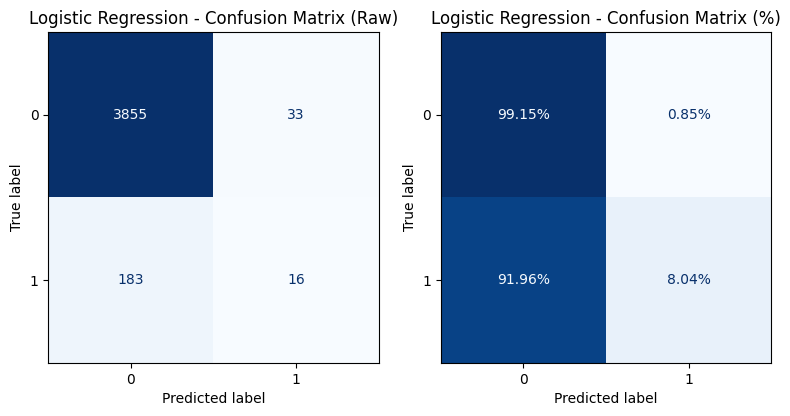

=== Logistic Regression (Tuned) ===
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3888
           1       0.33      0.08      0.13       199

    accuracy                           0.95      4087
   macro avg       0.64      0.54      0.55      4087
weighted avg       0.92      0.95      0.93      4087

PR AUC: 0.2107
ROC AUC: 0.8503
--------------------------------------------------


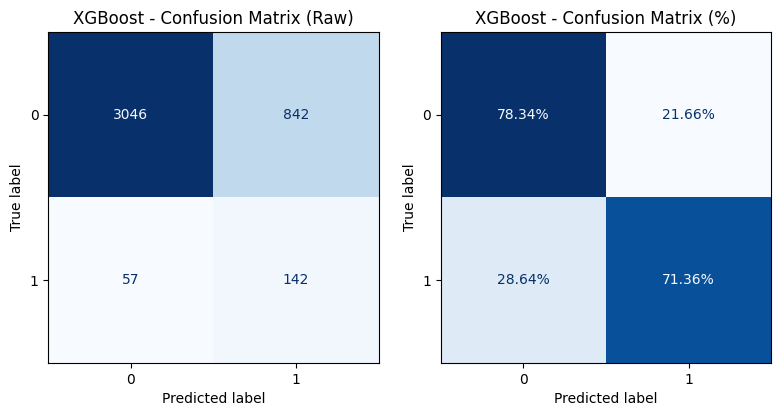

=== XGBoost (Tuned) ===
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      3888
           1       0.14      0.71      0.24       199

    accuracy                           0.78      4087
   macro avg       0.56      0.75      0.56      4087
weighted avg       0.94      0.78      0.84      4087

PR AUC: 0.2163
ROC AUC: 0.8395
--------------------------------------------------


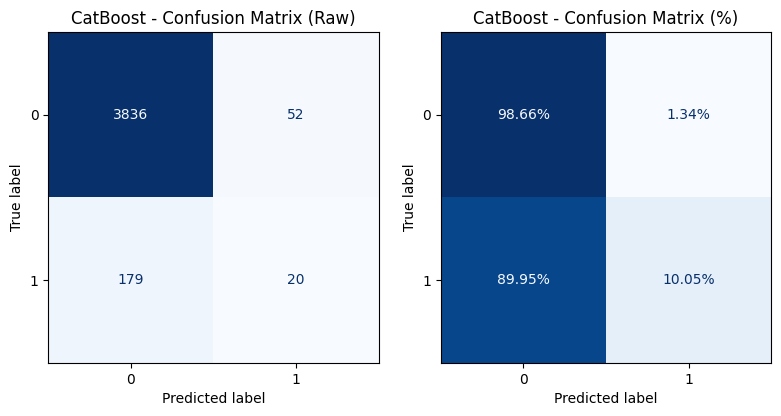

=== CatBoost (Tuned) ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3888
           1       0.28      0.10      0.15       199

    accuracy                           0.94      4087
   macro avg       0.62      0.54      0.56      4087
weighted avg       0.92      0.94      0.93      4087

PR AUC: 0.2246
ROC AUC: 0.8396
--------------------------------------------------


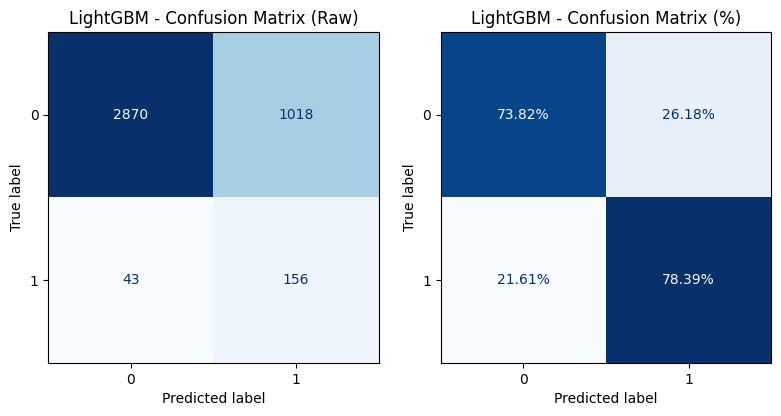

=== LightGBM (Tuned) ===
              precision    recall  f1-score   support

           0       0.99      0.74      0.84      3888
           1       0.13      0.78      0.23       199

    accuracy                           0.74      4087
   macro avg       0.56      0.76      0.54      4087
weighted avg       0.94      0.74      0.81      4087

PR AUC: 0.2100
ROC AUC: 0.8406
--------------------------------------------------


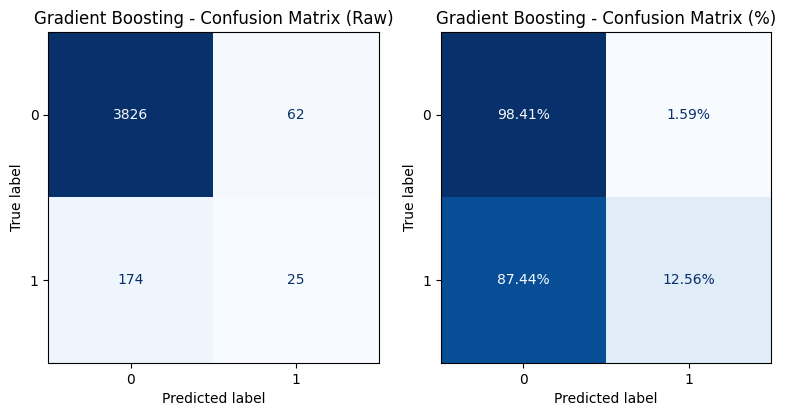

=== Gradient Boosting (Tuned) ===
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3888
           1       0.29      0.13      0.17       199

    accuracy                           0.94      4087
   macro avg       0.62      0.55      0.57      4087
weighted avg       0.92      0.94      0.93      4087

PR AUC: 0.2169
ROC AUC: 0.8328
--------------------------------------------------


In [66]:
detailed_reports_tuned = {}
overall_metrics_tuned = {}

for name in models.keys():

    if name == "Gradient Boosting":
        model = GradientBoostingClassifier(**best_params[name], random_state=42)
    elif name == "XGBoost":
        model = XGBClassifier(
            **best_params[name], eval_metric="logloss", use_label_encoder=False
        )
    elif name == "LightGBM":
        model = LGBMClassifier(**best_params[name], random_state=42)
    elif name == "CatBoost":
        model = CatBoostClassifier(**best_params[name], verbose=0)
    elif name == "Logistic Regression":
        model = LogisticRegression(**best_params[name])

    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

    y_scores = cross_val_predict(
        pipe, X_train, y_train, cv=5, method="predict_proba", n_jobs=1
    )

    y_pred_labels = (y_scores[:, 1] > 0.35).astype(int)

    report = classification_report(y_train, y_pred_labels, output_dict=True)
    pr_auc = average_precision_score(y_train, y_scores[:, 1])
    roc_auc = roc_auc_score(y_train, y_scores[:, 1])

    cm = confusion_matrix(y_train, y_pred_labels)
    cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    disp_raw = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp_raw.plot(ax=axes[0], cmap="Blues", values_format="d", colorbar=False)
    axes[0].set_title(f"{name} - Confusion Matrix (Raw)")
    axes[0].grid(False)

    disp_norm = ConfusionMatrixDisplay(
        confusion_matrix=cm_normalized, display_labels=[0, 1]
    )
    disp_norm.plot(ax=axes[1], cmap="Blues", values_format=".2%", colorbar=False)
    axes[1].set_title(f"{name} - Confusion Matrix (%)")
    axes[1].grid(False)

    plt.tight_layout()
    plt.show()

    detailed_reports_tuned[name] = pd.DataFrame(report).transpose()
    overall_metrics_tuned[name] = {
        "PR AUC": pr_auc,
        "ROC AUC": roc_auc,
        "Precision (1)": report["1"]["precision"],
        "Recall (1)": report["1"]["recall"],
        "F1 (1)": report["1"]["f1-score"],
    }

    print(f"=== {name} (Tuned) ===")
    print(classification_report(y_train, y_pred_labels))
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("-" * 50)

In [68]:
print("\n=== Model Comparison After Tuning ===")
metrics_df = pd.DataFrame.from_dict(overall_metrics_tuned, orient="index")
print(metrics_df.round(4))


=== Model Comparison After Tuning ===
                     PR AUC  ROC AUC  Precision (1)  Recall (1)  F1 (1)
Logistic Regression  0.2107   0.8503         0.3265      0.0804  0.1290
XGBoost              0.2163   0.8395         0.1443      0.7136  0.2401
CatBoost             0.2246   0.8396         0.2778      0.1005  0.1476
LightGBM             0.2100   0.8406         0.1329      0.7839  0.2272
Gradient Boosting    0.2169   0.8328         0.2874      0.1256  0.1748


XGBoost is the best choice from single model perspective:

    - Recall (1) 0.7136 (goal ≥ 0.70) with a threshold 0.35,
    - Best F1 (1) score,
    - PR AUC 0.2163 remain competitive (goal ≥ 0.2),
    - ROC‑AUC 0.8395 remain competitive (goal ≥ 0.8),
    - Precision (1)  0.1443 (goal ≥ 0.15),

**Precision-Recall curve for all tuned models**

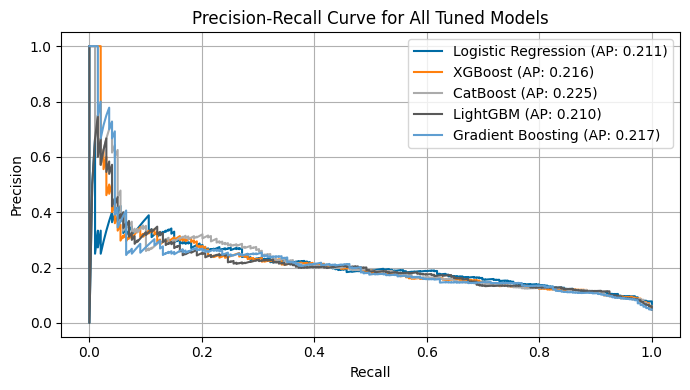

In [69]:
plt.figure(figsize=(7, 4))

for name in models.keys():
    if name == "Gradient Boosting":
        model = GradientBoostingClassifier(**best_params[name], random_state=42)
    elif name == "XGBoost":
        model = XGBClassifier(
            **best_params[name], eval_metric="logloss", use_label_encoder=False
        )
    elif name == "LightGBM":
        model = LGBMClassifier(**best_params[name], random_state=42)
    elif name == "CatBoost":
        model = CatBoostClassifier(**best_params[name], verbose=0)
    elif name == "Logistic Regression":
        model = LogisticRegression(**best_params[name], max_iter=1000)

    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

    y_scores = cross_val_predict(
        pipe, X_train, y_train, cv=5, method="predict_proba", n_jobs=1
    )[:, 1]

    precision, recall, _ = precision_recall_curve(y_train, y_scores)
    ap_score = average_precision_score(y_train, y_scores)

    plt.plot(recall, precision, label=f"{name} (AP: {ap_score:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for All Tuned Models")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

All models show very close performance for recall > 0.4.

**XGBoost model's feature importance using SHAP**

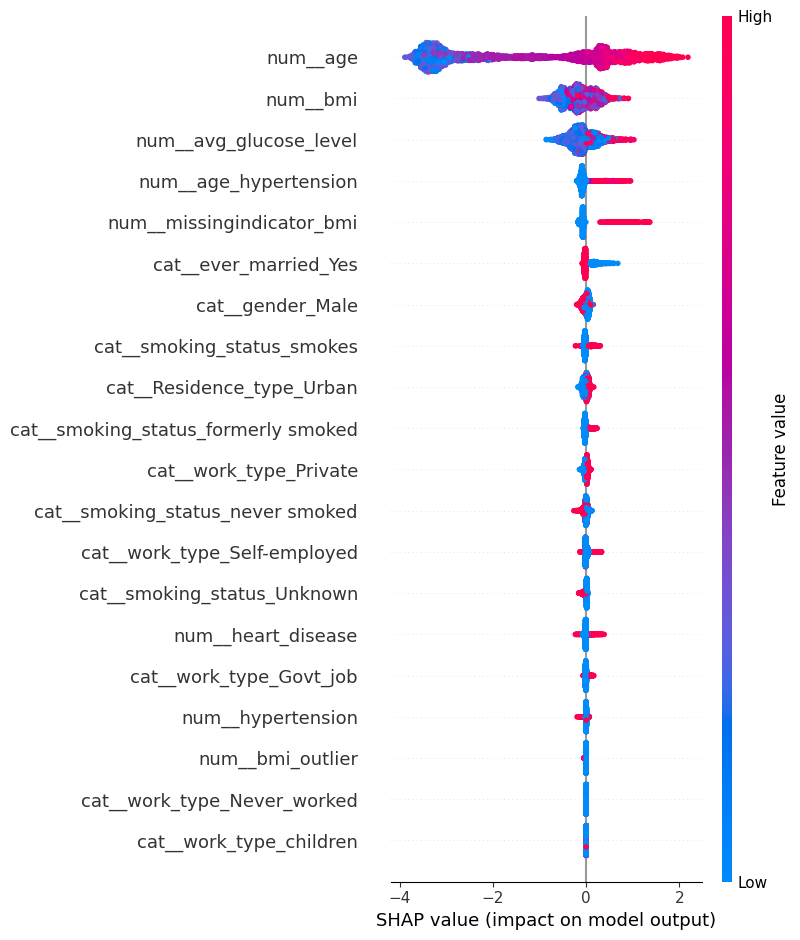

In [70]:
model = XGBClassifier(
    **best_params[name], eval_metric="logloss", use_label_encoder=False
)

pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

pipe.fit(X_train, y_train)

X_train_preprocessed = pipe.named_steps["preprocessor"].transform(X_train)

xgb_model = pipe.named_steps["classifier"]

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train_preprocessed)

cat_features = pipe.named_steps["preprocessor"].transformers_[1][2]
num_features = pipe.named_steps["preprocessor"].transformers_[0][2]

encoded_cat_names = (
    pipe.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .get_feature_names_out(cat_features)
)

transformed_feature_names = pipe.named_steps["preprocessor"].get_feature_names_out()

X_train_preprocessed_df = pd.DataFrame(
    X_train_preprocessed, columns=transformed_feature_names
)

shap.summary_plot(
    shap_values,
    features=X_train_preprocessed_df,
    feature_names=transformed_feature_names,
)

Top 3 most important features (XGBoost model, SHAP plot):

1. Age: This is the most important feature for stroke predictions.

    The spread of dots indicates its strong influence. Red dots (representing higher age values) are predominantly on the right side of the central axis (positive SHAP values). This means that higher age tends to increase the predicted probability of stroke. Conversely, blue dots (lower age values) are mostly on the left, indicating lower age decreases the predicted probability.

2. Body Mass Index: This is the second most important feature.

   Similar to age, red dots (higher BMI values) are mostly on the right side of the central axis, implying that higher BMI tends to increase the predicted probability of stroke. Lower BMI values (blue dots) push the prediction lower.

3. Average Glucose Level: This is the third most important feature.

    Again, red dots (higher average glucose levels) are primarily on the right side, indicating that higher glucose levels tend to increase the predicted probability of stroke. Lower glucose levels (blue dots) have a negative impact on the prediction.

**Permutation importance - XGBoost model**

              feature  importance
1                 age    0.485788
8                 bmi    0.354181
7   avg_glucose_level    0.246582
9      smoking_status    0.067759
10   age_hypertension    0.065419
4        ever_married    0.050302
3       heart_disease    0.043791


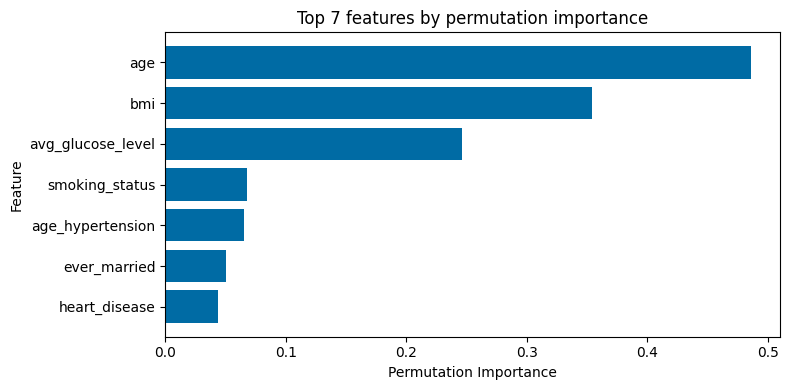

In [71]:
pipe.fit(X_train, y_train)

result_train = permutation_importance(
    pipe,
    X_train,
    y_train,
    scoring="average_precision",
    n_repeats=10,
    random_state=42,
)

importances_train = pd.DataFrame(
    {"feature": X_train.columns, "importance": result_train.importances_mean}
)

importances_train = importances_train.sort_values(
    by="importance", ascending=False
).head(7)

print(importances_train)

plt.figure(figsize=(8, 4))
plt.barh(importances_train["feature"], importances_train["importance"])
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 7 features by permutation importance")
plt.gca().invert_yaxis()
plt.tight_layout()

XGBoost model's feature permutation importance showed that the most important features are age, BMI, and average glucose level.

**Calibration plot for LogisticRegression, XGBoost and LightGBM**

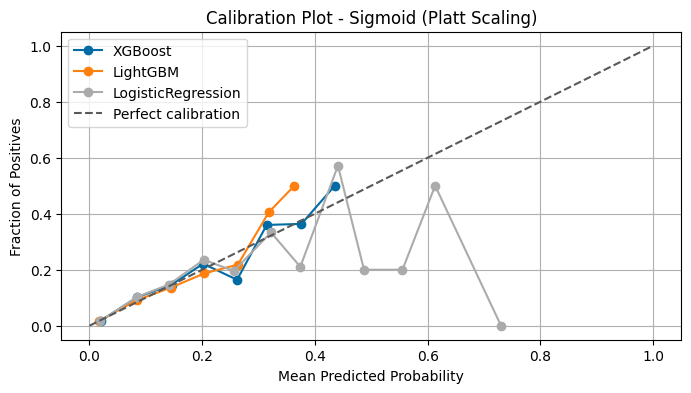

In [77]:
models = {
    "XGBoost": XGBClassifier(
        **best_params["XGBoost"],
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42,
    ),
    "LightGBM": LGBMClassifier(
        **best_params["LightGBM"],
        force_row_wise=True,
        verbose=-1,
        random_state=42,
    ),
    "LogisticRegression": LogisticRegression(
        **best_params["Logistic Regression"], max_iter=1000, random_state=42
    ),
}

plt.figure(figsize=(8, 4))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

    calibrated_clf = CalibratedClassifierCV(estimator=pipe, method="sigmoid", cv=cv)
    calibrated_clf.fit(X_train, y_train)

    y_probs_cv = cross_val_predict(
        calibrated_clf,
        X_train,
        y_train,
        cv=cv,
        method="predict_proba",
        n_jobs=1,
    )

    y_probs_cv_pos = y_probs_cv[:, 1]

    prob_true, prob_pred = calibration_curve(y_train, y_probs_cv_pos, n_bins=17)

    plt.plot(prob_pred, prob_true, marker="o", label=name)

plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot - Sigmoid (Platt Scaling)")
plt.legend()
plt.grid()
plt.show()

XGBoost shows the best calibration—its curve closely follows the diagonal, indicating that predicted probabilities match actual outcomes well.

LightGBM tends to overestimate risk at mid-level probabilities, as it sits above the diagonal.

Logistic Regression underestimates probabilities in the mid-range but remains fairly close to the ideal line with low probabilities.

### E. Ensembling

We will choose three models after calibration: LogisticRegression, XGBoost and LightGBM.

In [81]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

calibrated_estimators = [
    (
        "lr",
        CalibratedClassifierCV(
            estimator=Pipeline(
                [
                    ("preprocessor", preprocessor),
                    (
                        "classifier",
                        LogisticRegression(
                            **best_params["Logistic Regression"],
                            max_iter=1000,
                            class_weight="balanced",
                            random_state=42
                        ),
                    ),
                ]
            ),
            method="sigmoid",
            cv=cv,
        ),
    ),
    (
        "xgb",
        CalibratedClassifierCV(
            estimator=Pipeline(
                [
                    ("preprocessor", preprocessor),
                    (
                        "classifier",
                        XGBClassifier(
                            **best_params["XGBoost"],
                            use_label_encoder=False,
                            eval_metric="logloss",
                            random_state=42
                        ),
                    ),
                ]
            ),
            method="sigmoid",
            cv=cv,
        ),
    ),
    (
        "lgbm",
        CalibratedClassifierCV(
            estimator=Pipeline(
                [
                    ("preprocessor", preprocessor),
                    (
                        "classifier",
                        LGBMClassifier(
                            **best_params["LightGBM"],
                            force_row_wise=True,
                            verbose=-1,
                            random_state=42
                        ),
                    ),
                ]
            ),
            method="sigmoid",
            cv=cv,
        ),
    ),
]

voting_clf = VotingClassifier(
    estimators=calibrated_estimators, voting="soft", n_jobs=-1
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                                     estimator=Pipeline(steps=[('preprocessor',
                                                                                ColumnTransformer(transformers=[('num',
                                                                                                                 Pipeline(steps=[('imputer',
                                                                                                                                  SimpleImputer(add_indicator=True,
                                                                                                                                                strategy='median')),
                                                                                                                                 ('scaler',
                                                                                                                                  StandardScaler())]),
                                                                                                                 ['age',
                                                                                                                  'hypertension',
                                                                                                                  'heart_disease',
                                                                                                                  'av...
                                                                                                                  'smoking_status'])])),
                                                                               ('classifier',
                                                                                LGBMClassifier(colsample_bytree=0.6260206371941118,
                                                                                               force_row_wise=True,
                                                                                               learning_rate=0.011711509955524094,
                                                                                               max_depth=8,
                                                                                               n_estimators=306,
                                                                                               num_leaves=69,
                                                                                               random_state=42,
                                                                                               reg_alpha=9.488855372533333,
                                                                                               reg_lambda=9.656320330745594,
                                                                                               scale_pos_weight=12.317562873630456,
                                                                                               subsample=0.6682096494749166,
                                                                                               verbose=-1))])))],
                 n_jobs=-1, voting='soft')

**Cross-validation on the ensemble.**

In [99]:
y_pred_cv = cross_val_predict(
    voting_clf, X_train, y_train, cv=5, method="predict", n_jobs=1
)

y_probs_cv = cross_val_predict(
    voting_clf, X_train, y_train, cv=5, method="predict_proba", n_jobs=1
)

threshold = 0.07
y_pred_cv = (y_probs_cv[:, 1] > threshold).astype(int)

precision = precision_score(y_train, y_pred_cv, pos_label=1)
recall = recall_score(y_train, y_pred_cv, pos_label=1)
f1 = f1_score(y_train, y_pred_cv, pos_label=1)
pr_auc = average_precision_score(y_train, y_probs_cv[:, 1])
roc_auc = roc_auc_score(y_train, y_probs_cv[:, 1])

results = pd.DataFrame(
    {
        "Metric": ["PR-AUC", "ROC-AUC", "Precision (C1)", "Recall (C1)", "F1 (C1)"],
        "Score": [pr_auc, roc_auc, precision, recall, f1],
    }
)

print(
    f"\n=== Cross-Validated Metrics: VotingClassifier Ensemble ===\n {results.round(4)}"
)


=== Cross-Validated Metrics: VotingClassifier Ensemble ===
            Metric   Score
0          PR-AUC  0.2148
1         ROC-AUC  0.8488
2  Precision (C1)  0.1578
3     Recall (C1)  0.7186
4         F1 (C1)  0.2588


In [91]:
print("\n=== Model Comparison After Tuning - XGBoost ===")
metrics_df = pd.DataFrame.from_dict(overall_metrics_tuned, orient="index")
print(metrics_df.loc["XGBoost"].round(4))


=== Model Comparison After Tuning - XGBoost ===
PR AUC           0.2163
ROC AUC          0.8395
Precision (1)    0.1443
Recall (1)       0.7136
F1 (1)           0.2401
Name: XGBoost, dtype: float64


While the PR-AUC of the ensemble slightly underperforms compared to XGBoost, it demonstrates improved ROC-AUC and F1 scores for the positive class. This suggests the ensemble achieves a more balanced trade-off between precision and recall, making it more reliable overall—especially in scenarios where both false positives and false negatives carry weight.

**Optimal threshold for Ensemble**

Develop a model with ≥70% recall (minimize missed strokes) while keeping precision ≥15%.

In [92]:
precision_vals, recall_vals, thresholds = precision_recall_curve(
    y_train, y_probs_cv[:, 1]
)

for p, r, t in zip(precision_vals, recall_vals, thresholds):
    if r >= 0.7 and p >= 0.15:
        print(f"Threshold: {t:.3f}, Precision: {p:.3f}, Recall: {r:.3f}")
        break

Threshold: 0.062, Precision: 0.150, Recall: 0.749


**Ensemble Precision/Recall curve and confusion matrix**

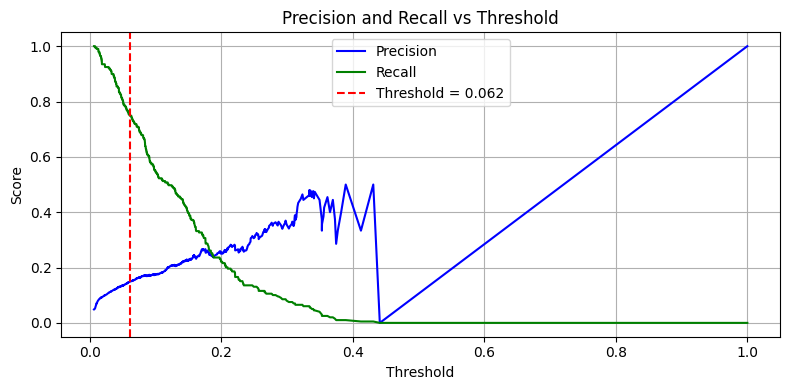

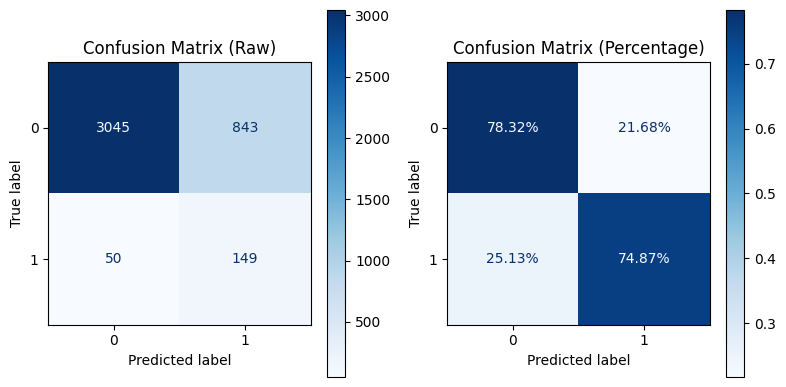

In [93]:
y_probs_cv = cross_val_predict(
    voting_clf, X_train, y_train, cv=5, method="predict_proba", n_jobs=1
)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_train, y_probs_cv)
thresholds = np.append(thresholds, 1.0)

plt.figure(figsize=(8, 4))
plt.plot(thresholds, precision, label="Precision", color="blue")
plt.plot(thresholds, recall, label="Recall", color="green")
plt.axvline(0.062, color="red", linestyle="--", label="Threshold = 0.062")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

y_pred_045 = (y_probs_cv >= 0.062).astype(int)
cm = confusion_matrix(y_train, y_pred_045)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=axs[0], cmap="Blues", values_format="d")
axs[0].set_title("Confusion Matrix (Raw)")

cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
disp_percent = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized, display_labels=[0, 1]
)
disp_percent.plot(ax=axs[1], cmap="Blues", values_format=".2%")
axs[1].set_title("Confusion Matrix (Percentage)")

plt.tight_layout()
plt.show()

The model is achieving high recall, catching nearly 75% of all true stroke cases. This aligns well with the goal of minimizing missed strokes. At the same time, precision sits right at the 15% threshold, meaning that while many flagged cases are false positives, the model is still meeting the minimum bar for targeting precision.

This kind of performance is often acceptable in critical applications like stroke detection, where it's better to raise more false alarms than to miss actual cases

### F. Ensemble evaluation on Test set

In [97]:
y_proba = voting_clf.predict_proba(X_test)[:, 1]
threshold = 0.062
y_pred_thresh = (y_proba >= threshold).astype(int)

report_voting_clf = classification_report(y_test, y_pred_thresh)

precision = precision_score(y_test, y_pred_thresh, pos_label=1)
recall = recall_score(y_test, y_pred_thresh, pos_label=1)
f1 = f1_score(y_test, y_pred_thresh, pos_label=1)
pr_auc = average_precision_score(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

results_test = pd.DataFrame(
    {
        "Metric": ["PR-AUC", "ROC-AUC", "Precision (C1)", "Recall (C1)", "F1 (C1)"],
        "Score": [pr_auc, roc_auc, precision, recall, f1],
    }
)

print("\n=== Test Validation: VotingClassifier Ensemble ===")
print(results_test.round(4))


=== Test Validation: VotingClassifier Ensemble ===
           Metric   Score
0          PR-AUC  0.2357
1         ROC-AUC  0.8358
2  Precision (C1)  0.1556
3     Recall (C1)  0.8000
4         F1 (C1)  0.2606


In [103]:
print(f"\n=== Train Cross-Validated Metrics: Ensemble ===\n {results.round(4)}")


=== Train Cross-Validated Metrics: Ensemble ===
            Metric   Score
0          PR-AUC  0.2148
1         ROC-AUC  0.8488
2  Precision (C1)  0.1578
3     Recall (C1)  0.7186
4         F1 (C1)  0.2588


ROC-AUC: 0.8358 - Still strong on unseen data, indicating good generalization.

PR-AUC: 0.2357 - Slightly improved over training; encouraging given your high-recall focus.

Precision (C1): 15.6%, Recall (C1): 80.0% - The recall improves even more here while still just meeting the precision cutoff.

F1 Score: 0.2606 - Slightly better than on training data.

VotingClassifier ensemble is working as intended: it's capturing most stroke cases (high recall) while maintaining just enough precision to meet predefined safety net. The slight bump in test recall and PR-AUC suggests it’s not overfitting—a positive sign.

**Ensemble confusion matrix for test set**

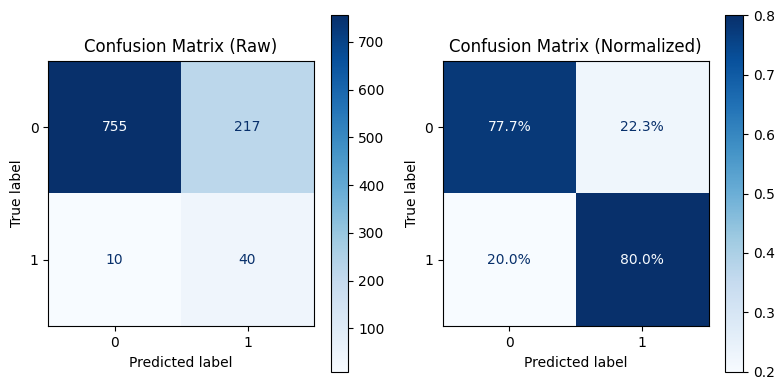

In [104]:
cm = confusion_matrix(y_test, y_pred_thresh)
cm_normalized = confusion_matrix(y_test, y_pred_thresh, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp1.plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title("Confusion Matrix (Raw)")
axes[0].grid(False)

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[0, 1])
disp2.plot(ax=axes[1], cmap="Blues", values_format=".1%")
axes[1].set_title("Confusion Matrix (Normalized)")
axes[1].grid(False)

plt.tight_layout()
plt.show()

True Positives (40): Correctly predicted stroke cases.

False Positives (217): Non-stroke cases mistakenly flagged as strokes.

False Negatives (10): Missed stroke cases — critical in a high-recall setting.

True Negatives (755): Correctly predicted non-stroke cases.

The model is highly sensitive, capturing 80% of stroke cases — excellent for a scenario where missing a stroke is risky. At the same time, precision is just above the 15% threshold, meaning a large number of false positives are being tolerated to prioritize catching true stroke events.

This performance matches your objective well: it minimizes missed strokes (high recall), even though it means handling a larger volume of false alarms.

**Targeted subgroup error analysis**

         Feature  FP Rate  FN Rate
0       Age ≥ 65    0.721    0.000
3   Hypertension    0.676    0.000
4  Heart Disease    0.523    0.000
1       BMI ≥ 30    0.261    0.011
2         Smoker    0.214    0.012
6          Urban    0.212    0.006
5         Female    0.203    0.008


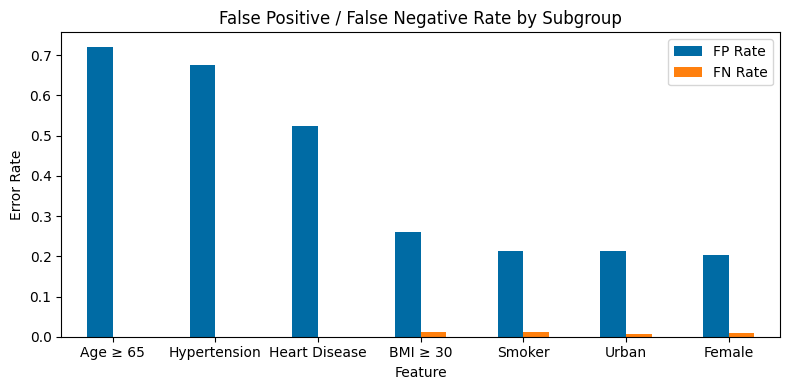

In [126]:
df_test = X_test.copy()
df_test["y_true"] = y_test
df_test["y_pred"] = y_pred_thresh

df_test["error_type"] = "TN"
df_test.loc[(df_test["y_true"] == 1) & (df_test["y_pred"] == 1), "error_type"] = "TP"
df_test.loc[(df_test["y_true"] == 0) & (df_test["y_pred"] == 1), "error_type"] = "FP"
df_test.loc[(df_test["y_true"] == 1) & (df_test["y_pred"] == 0), "error_type"] = "FN"

subgroups = {
    "Age ≥ 65": df_test["age"] >= 65,
    "BMI ≥ 30": df_test["bmi"] >= 30,
    "Smoker": df_test["smoking_status"] == "smokes",
    "Hypertension": df_test["hypertension"] == 1,
    "Heart Disease": df_test["heart_disease"] == 1,
    "Female": df_test["gender"] == "Female",
    "Urban": df_test["Residence_type"] == "Urban",
}

results_error_analysis = []

for name, condition in subgroups.items():
    subset = df_test[condition]
    fp_rate = (subset["error_type"] == "FP").mean()
    fn_rate = (subset["error_type"] == "FN").mean()
    results_error_analysis.append((name, fp_rate, fn_rate))

df_errors = pd.DataFrame(
    results_error_analysis, columns=["Feature", "FP Rate", "FN Rate"]
)
df_errors = df_errors.sort_values(by="FP Rate", ascending=False)

print(df_errors.round(3))

df_errors.plot(
    x="Feature",
    kind="bar",
    stacked=False,
    figsize=(8, 4),
    ylabel="Error Rate",
    title="False Positive / False Negative Rate by Subgroup",
)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Age ≥ 65 (0.721), Hypertension (0.676), and Heart Disease (0.523)  have very high false positive rates, model often incorrectly predicts stroke for these groups. These groups tend to be over-flagged by the model, which may indicate the model is overestimating stroke risk for them.

All above subgroups have very low FN rates, meaning the model is extremely cautious not to miss true stroke cases in them.

BMI ≥ 30, Smoker, Urban, Female: all show moderate FP rates (~20–26%). These groups may be second-tier contributors to prediction errors — likely correlates of other risk factors. Small FN risk is these subgroups.

**Precision-Recall, ROC curves**

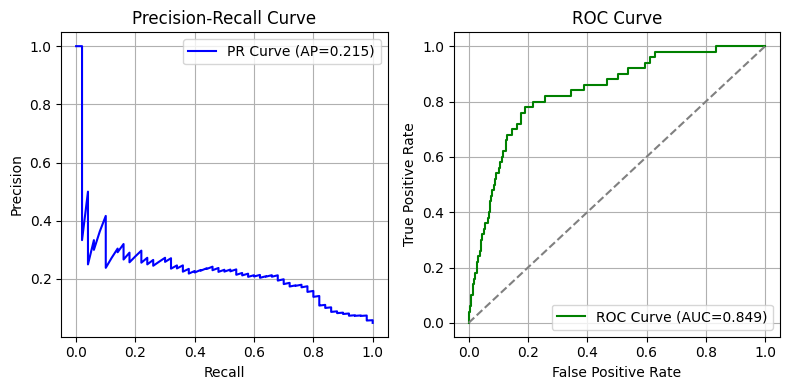

In [138]:
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(recall_vals, precision_vals, label=f"PR Curve (AP={pr_auc:.3f})", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.3f})", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

PR AUC of 0.215 is modest:
    
    On average, when the model predicts a stroke, about 21.5% of those predictions are actually correct, across all thresholds.


ROC AUC of 0.849 is very strong:
    
    There is an 84.9% chance the model will assign a higher score to a stroke patient than to a non-stroke patient.

**Ensemble feature permutation importance**

In [134]:
result = permutation_importance(
    voting_clf,
    X_test,
    y_test,
    n_repeats=5,
    random_state=42,
    scoring="roc_auc",
)

importance_df = pd.DataFrame(
    {
        "Feature": X_test.columns,
        "Importance": result.importances_mean,
    }
).sort_values("Importance", ascending=False)

print(importance_df.head(10))

              Feature  Importance
1                 age    0.270782
7   avg_glucose_level    0.010733
8                 bmi    0.005551
5           work_type    0.002963
10   age_hypertension    0.002128
3       heart_disease    0.001942
9      smoking_status    0.001021
11        bmi_outlier    0.000724
0              gender    0.000387
4        ever_married   -0.000300


Results show consistent top features across both training and test: age, average glucose level and BMI.

**Model deployment**

In [139]:
joblib.dump(voting_clf, "voting_model.pkl")

['voting_model.pkl']

## 5. Conclusion

Key Findings:

    1.   After hyperparameter tuning XGBoost was the best choice from single model perspective:

        - Recall (1) 0.7136 (goal ≥ 0.70) with a threshold 0.35,
        - Best F1 (1) score 0.2401,
        - PR AUC 0.2163 remain competitive (goal ≥ 0.2),
        - ROC‑AUC 0.8395 remain competitive (goal ≥ 0.8),
        - Precision (1)  0.1443 (goal ≥ 0.15),
        
        Top 3 most important features for XGBoost model: age, BMI, average glucose Level.
        

    2. Ensemble  model (LogisticRegression, XGBoost and LightGBM) advantage:

        While the PR-AUC of the ensemble slightly underperforms compared to XGBoost, it demonstrates improved ROC-AUC and F1 scores for the positive class. This suggests the ensemble achieves a more balanced trade-off between precision and recall.

        Ensemle model achieved all objectives (recall (1) ≥70%, precision (1) ≥15%, ROC-AUC ≥0.8 and PR-AUC ≥0.2) on train set, and achieved even better results for RP-AUC and F1(1) on test set.
        
        
    3. Top 3 clinical risk factors driving predictions (was the same for XGBoost and Ensemble model):

        - Age, 
        - Average glucose level,
        - BMI.
        Higher values of these factors increase stroke risk.
        

    4. Model Evaluation:

        Applied cross-validation, confusion matrices, PR ROC curves, and error analisys to ensure model robustness and interpretability.
        

Suggestions for Improvement:

    Expand feature engineering:

        Using clinical domain knowledge could add interaction terms, new derived features.
        
    Address data imbalance more explicitly:
    
        Further threshold optimization after error analisys.

    Test generalization on external dataset.
    